# Clustering

This notebook implements kmeans in pytorch the goal is to vectorize kmeans as much as possible. This is a part of lecture 12 mean shift cluster fast ai course. <br>
Kmneas implementation follows [amazing blog post](https://www.gaohongnan.com/influential/kmeans_clustering/02_concept.html) by Mr. Gao Hongnan.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters=6
n_samples =250
centroids = torch.rand(n_clusters, 2)*70-35
centroids
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
torch.tensor([[5.,2.5],[2.5,5.]])
torch.diag(tensor([5.,5.]))
def sample(m): return MultivariateNormal(m, torch.tensor([[15.,7.5],[7.5,15.]])).sample((n_samples,))

slices = [sample(c) for c in centroids]
data = torch.cat(slices).to(device)
data.shape

torch.Size([1500, 2])


* c => all points in the cluster
* v => cluster centers 


## Thought process

In [4]:
X = data.clone().to(device)

In [5]:
k = 6
v = X[torch.randint(X.shape[0],(6,))]

In [6]:
point_center_dist = (v[:,None] - X ).norm(2, dim=2);point_center_dist

tensor([[46.043, 47.981, 55.920,  ..., 46.785, 43.746, 46.892],
        [21.451, 26.809, 29.620,  ...,  9.669,  3.332,  6.598],
        [35.531, 37.500, 45.404,  ..., 37.064, 35.197, 37.807],
        [ 4.979,  4.104,  5.387,  ..., 17.636, 26.766, 23.356],
        [15.208, 20.531, 23.838,  ...,  6.403,  8.463,  7.948],
        [50.248, 55.621, 57.782,  ..., 36.996, 27.530, 31.467]], device='cuda:0')

In [7]:
cluster_assigment = point_center_dist.argmin(0).to(device); cluster_assigment

tensor([3, 3, 3,  ..., 4, 1, 1], device='cuda:0')

In [8]:
cluster_binary_mask = torch.nn.functional.one_hot(cluster_assigment, num_classes=k).type(torch.float).to(device)

In [9]:
torch.zeros(cluster_assigment.size(0), k, device=device).scatter_(1, cluster_assigment[...,None], 1)

tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], device='cuda:0')

In [10]:
X.T.shape, cluster_binary_mask.shape

(torch.Size([2, 1500]), torch.Size([1500, 6]))

In [11]:
(cluster_binary_mask.T @ X) 

tensor([[-2719.513,  1826.229],
        [ 3864.467,   471.391],
        [-5466.883, 12903.361],
        [ 6786.455,  7436.685],
        [ 3656.357,  1113.789],
        [ 7749.357, -6310.159]], device='cuda:0')

In [12]:
(cluster_binary_mask.T @ X) / cluster_binary_mask.sum(0).clip(1e-6)[:,None]

tensor([[-17.212,  11.558],
        [ 29.276,   3.571],
        [ -9.266,  21.870],
        [ 26.718,  29.278],
        [ 31.520,   9.602],
        [ 30.997, -25.241]], device='cuda:0')

# Kmeans update

In [13]:
def kmeans_update(v):
	c = [[] for _ in range(len(v))]
	for point in X:
		dist = []
		for center in v:
			dist.append(((center - point)**2).sum()**0.5)
		c[torch.tensor(dist).argmin()].append(point)

	
	for idx, cluster in enumerate(c):
		c[idx] = cluster = torch.stack(cluster)
		v[idx] = cluster.mean(dim=0)
	return c

In [14]:
v.device

device(type='cuda', index=0)

In [15]:
def kmeans_update_vector(X, v,*, cluster_binary_mask=None):
	point_center_dist = (v[:,None] - X ).norm(2, dim=2)
	cluster_idx = point_center_dist.argmin(0); 
	if cluster_binary_mask is None:
		# This is exactly the same as under the hood of onehot encoder 
		cluster_binary_mask = torch.zeros(cluster_idx.size(0), k, device=device).scatter_(1, cluster_idx[...,None], 1)
	else:
		cluster_binary_mask = cluster_binary_mask.zero_().scatter_(1, cluster_idx[...,None], 1)
	v.copy_((cluster_binary_mask.T @ X))
	v.div_(cluster_binary_mask.sum(0).clip(1e-6)[:,None])
	return cluster_idx

In [16]:
kmeans_update_vector(X,v)

tensor([3, 3, 3,  ..., 4, 1, 1], device='cuda:0')

# Kmeans ++ initialization

## Process

In [17]:
X = data.clone()
k = 6
v = X[random.sample(list(range(len(X))), 1)]

In [18]:
v1 = X[random.sample(list(range(len(X))), 1)];v1

tensor([[32.922, 31.727]], device='cuda:0')

In [19]:
from torch.utils.data import WeightedRandomSampler as WRS
X = data.clone()
k = 6
dist = []
v = []
v.append(X[random.sample(list(range(len(X))), 1)])
for i in range(k-1):

	dist.append(((v[-1]-X)**2).sum(1).sqrt())
	weight = torch.stack(dist).min(dim=0)[0]

	v.append( X[list(WRS(weight,1, replacement=False))])


In [20]:
weight.shape, weight

(torch.Size([1500]),
 tensor([21.784, 27.201, 29.308,  ...,  8.723,  1.254,  4.493], device='cuda:0'))

In [21]:
def kmeans_plus_plus_init(k):
	""""
	First implementation
	"""
	X = data.clone()
	dist, v = [], []
	v.append(X[random.sample(list(range(len(X))), 1)])
	for i in range(k-1):
		dist.append(((v[-1]-X)**2).sum(1).sqrt())
		weight = torch.stack(dist).min(dim=0)[0]
		v.append( X[list(WRS(weight,1, replacement=False))])
	return torch.cat(v)

In [22]:
X = data.clone()
dist, v = [], []
v.append(X[random.sample(list(range(len(X))), 1)[0]])
n_local_trials = 2 + int(torch.log(torch.tensor(k)))
# for i in range(k-1):
i = 0

In [23]:
dist.append(((v[-1]-X)**2).sum(1).sqrt())
weight = torch.stack(dist).min(dim=0)[0]


In [24]:
idx = torch.multinomial(weight, n_local_trials, replacement=False)



In [25]:
dist_to_candidates = (X[idx, None] - X).norm(2, dim=2);dist_to_candidates

tensor([[52.339, 57.746, 59.456,  ..., 38.700, 29.434, 33.057],
        [49.353, 54.765, 55.288,  ..., 35.041, 26.710, 29.336],
        [50.709, 56.121, 57.757,  ..., 37.013, 27.786, 31.359]], device='cuda:0')

In [26]:
interia = torch.minimum(dist_to_candidates,weight ).sum(1);interia

tensor([33346.609, 33170.469, 32832.109], device='cuda:0')

In [27]:
best_idx = idx[interia.argmin()]

In [28]:
v.append( X[best_idx])


## Vectorize implementation

In [29]:
def kmeans_plus_plus_init_vector(X, k):
    """"
	Generate n_local_trials candidate centers and pick one which minimalize overall distance from each point to the closest center 
	"""
    n_local_trials = 2 + int(torch.log(torch.tensor(k, dtype=torch.float)))

    v = torch.zeros(k, X.size(1), dtype=torch.float, device=X.device)
    shortest_distance_center = torch.full((X.size(0),), float('inf'), device=X.device)
    best_candidate_distance = None

    v[0] = X[torch.randint(X.size(0), (1,), device=X.device)]

    for i in range(k - 1):
        # Use cached distance if available, else compute
        center_distance = best_candidate_distance if best_candidate_distance is not None else (v[i] - X).norm(2, dim=1)
        torch.minimum(shortest_distance_center, center_distance, out=shortest_distance_center)

        idx = torch.multinomial(shortest_distance_center, n_local_trials, replacement=False)

        # Compute distances of candidates to all points
        candidate_distance = (X[idx].unsqueeze(1) - X).norm(2, dim=2)
        inertia = torch.minimum(candidate_distance, shortest_distance_center).sum(1)

        best_idx = idx[inertia.argmin()]
        # Cache norm for next iteration
        best_candidate_distance = candidate_distance[inertia.argmin()]
        v[i + 1] = X[best_idx]

    return v


In [30]:
v = kmeans_plus_plus_init_vector(X,6)

In [31]:
from itertools import zip_longest
def plot(X, v, cluster_assigment=[],  ax=None):
	_,ax = plt.subplots() if ax is None else (None, ax)
	if not len(cluster_assigment):
		ax.scatter(X.cpu()[:,0], X.cpu()[:,1], s=1)
	for i, centroid_new in enumerate(v):
		if len(cluster_assigment):
			ax.scatter(X[cluster_assigment==i,0], X[cluster_assigment==i,1], s=1)
		ax.plot(*centroid_new.cpu(), markersize=10, marker="x", color='k', mew=5)
		ax.plot(*centroid_new.cpu(), markersize=5, marker="x", color='g', mew=2)

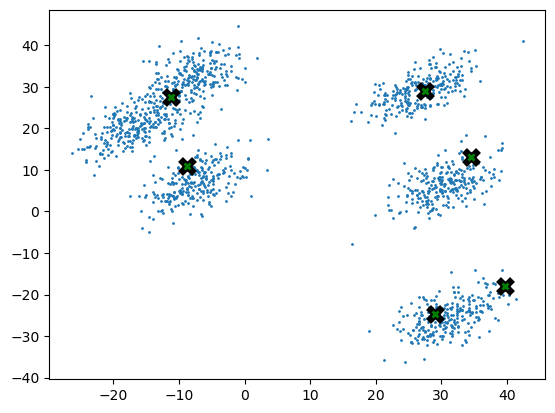

In [32]:
plot(X,v)

# Animation

In [33]:
def do_one(d, X,ax):
	cluster_assigment = [] if not d  else kmeans_update_vector(X, v)
	ax.clear()
	plot(X,v,cluster_assigment,ax)


In [34]:
from matplotlib.animation import PillowWriter
# create your own animation
device = 'cpu'
X = data.clone().cpu()
fig,ax = plt.subplots()
v = kmeans_plus_plus_init_vector(X, k)
ani = FuncAnimation(fig, partial(do_one, X=X, ax=ax), frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())


In [35]:
ani.save("kmeans_animation.gif", writer=PillowWriter(fps=2))
device = 'cuda'

# Benchmark

### sklearn

In [36]:
from sklearn.cluster import KMeans


In [37]:
X = data.clone()

In [38]:
%timeit km = KMeans(6, max_iter=5, tol=0).fit_predict(X.cpu())

2.68 ms ± 379 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
km = KMeans(6, max_iter=5, tol=0)
km.fit_predict(X.cpu())

array([0, 0, 0, ..., 4, 4, 4], shape=(1500,), dtype=int32)

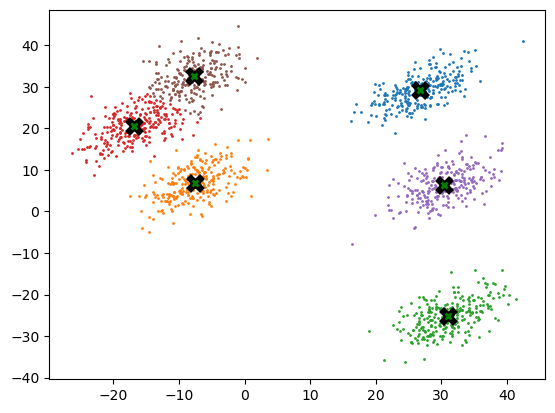

In [40]:
plot(X.cpu(), torch.from_numpy(km.cluster_centers_),torch.from_numpy(km.labels_))

### own implementation

In [41]:
X = data.clone()

In [42]:
device = 'cpu'
X = X.cpu()

In [43]:
def kmeans(X,k, niter=5):
	v = kmeans_plus_plus_init_vector(X, k)
	binary_mask = torch.empty(X.size(0), k, device=device)
	for _ in range(niter):
		c = kmeans_update_vector(X,v, cluster_binary_mask=binary_mask)
	return v,c

In [44]:
%timeit -n 10 v, cluster_assigment = kmeans(X, k)

3.82 ms ± 729 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
device = 'cuda'
X = X.cuda()

In [46]:
X.device

device(type='cuda', index=0)

In [47]:
%timeit -n 10 v, cluster_assigment = kmeans(X, k)

6 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
v, cluster_assigment = kmeans(X, k)

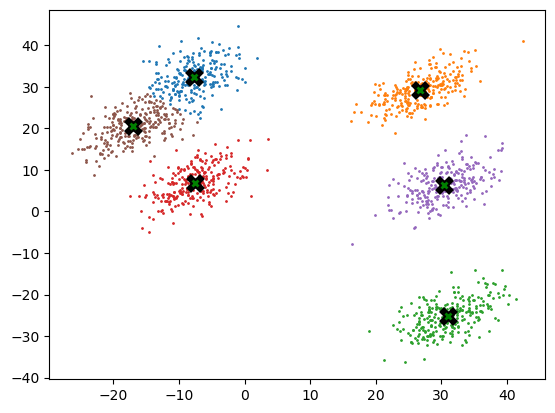

In [49]:
plot(X.cpu(),v.cpu(),cluster_assigment.cpu() )

### scaled data sklearn

In [50]:
n_samples = 100000
def sample(m): return MultivariateNormal(m, torch.tensor([[15.,7.5],[7.5,15.]])).sample((n_samples,))
centroids = torch.rand(n_clusters, 2)*70-35
slices = [sample(c) for c in centroids]
data_big = torch.cat(slices)
data_big.shape

torch.Size([600000, 2])

In [51]:
X = data_big.clone()

In [52]:
%timeit -n 10 km = KMeans(6).fit_predict(X.cpu())

197 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
km = KMeans(6)
km.fit_predict(X)


array([5, 5, 5, ..., 4, 4, 4], shape=(600000,), dtype=int32)

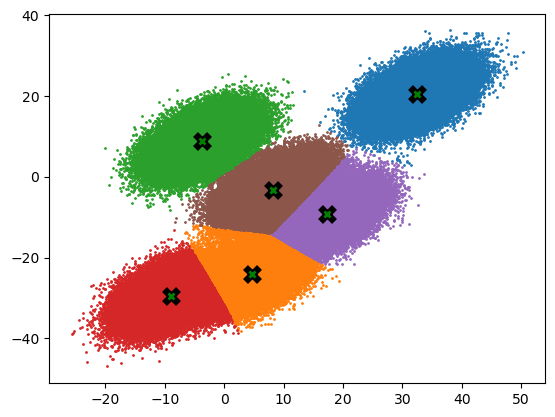

In [54]:
plot(X.cpu(), torch.from_numpy(km.cluster_centers_),torch.from_numpy(km.labels_))

### scaled data own 

In [55]:
X = data_big.clone().cuda()


In [56]:
torch.cuda.synchronize()
%timeit  kmeans(X, k)
torch.cuda.synchronize()

8.16 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
v, cluster_assigment = kmeans(X, k)

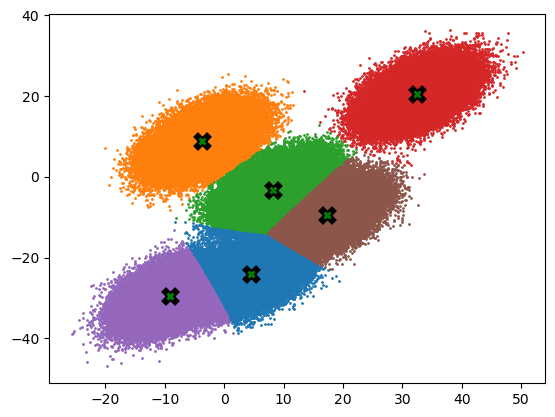

In [58]:
plot(X.cpu(),v.cpu(),cluster_assigment.cpu() )

In [60]:
import torch
import torch.profiler

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    # Run the code you want to profile
    kmeans(X, k)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.73%     495.751us         0.73%     495.751us      19.830us           4 b           4 b      16.03 Mb      16.03 Mb            25  
                                               aten::to         0.01%       5.398us         0.01%       5.398us       0.900us           0 b           0 b           0 b           0 b             6  
         

# Conclustion

So it seems that the CUDA vectorized KMeans is faster on larger datasets — which makes sense. There was some timing noise at first, but overall, it's a small win. And hey, faster is always more fun! 😄